C:\Users\Adrian\AppData\Local\Temp\ipykernel_63976\1154780409.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_products_by_category = product_turnover.groupby('product_category_name_english', group_keys=False).apply(


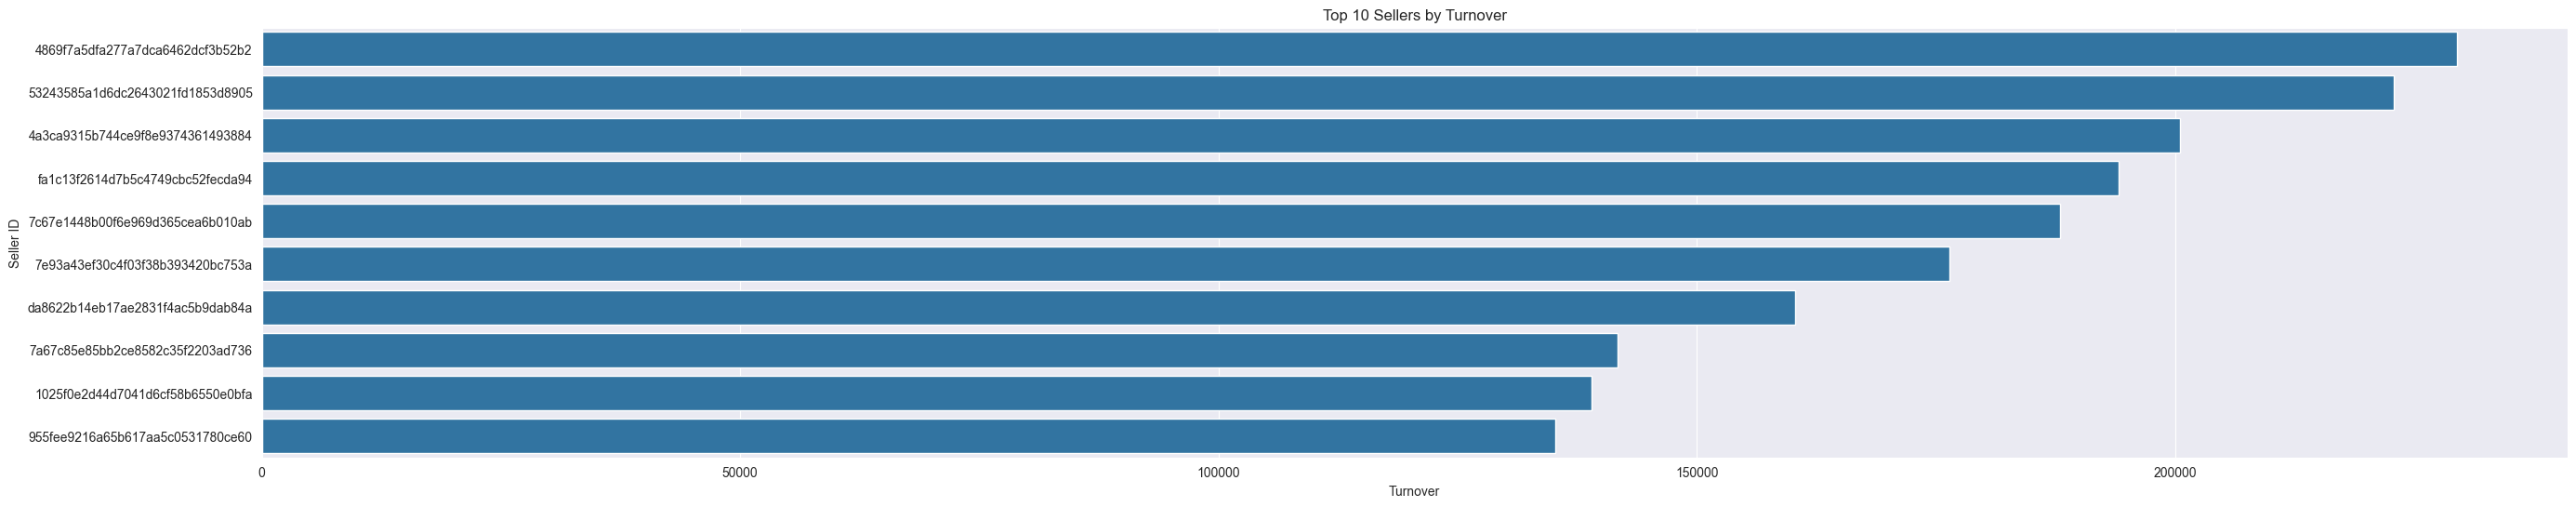

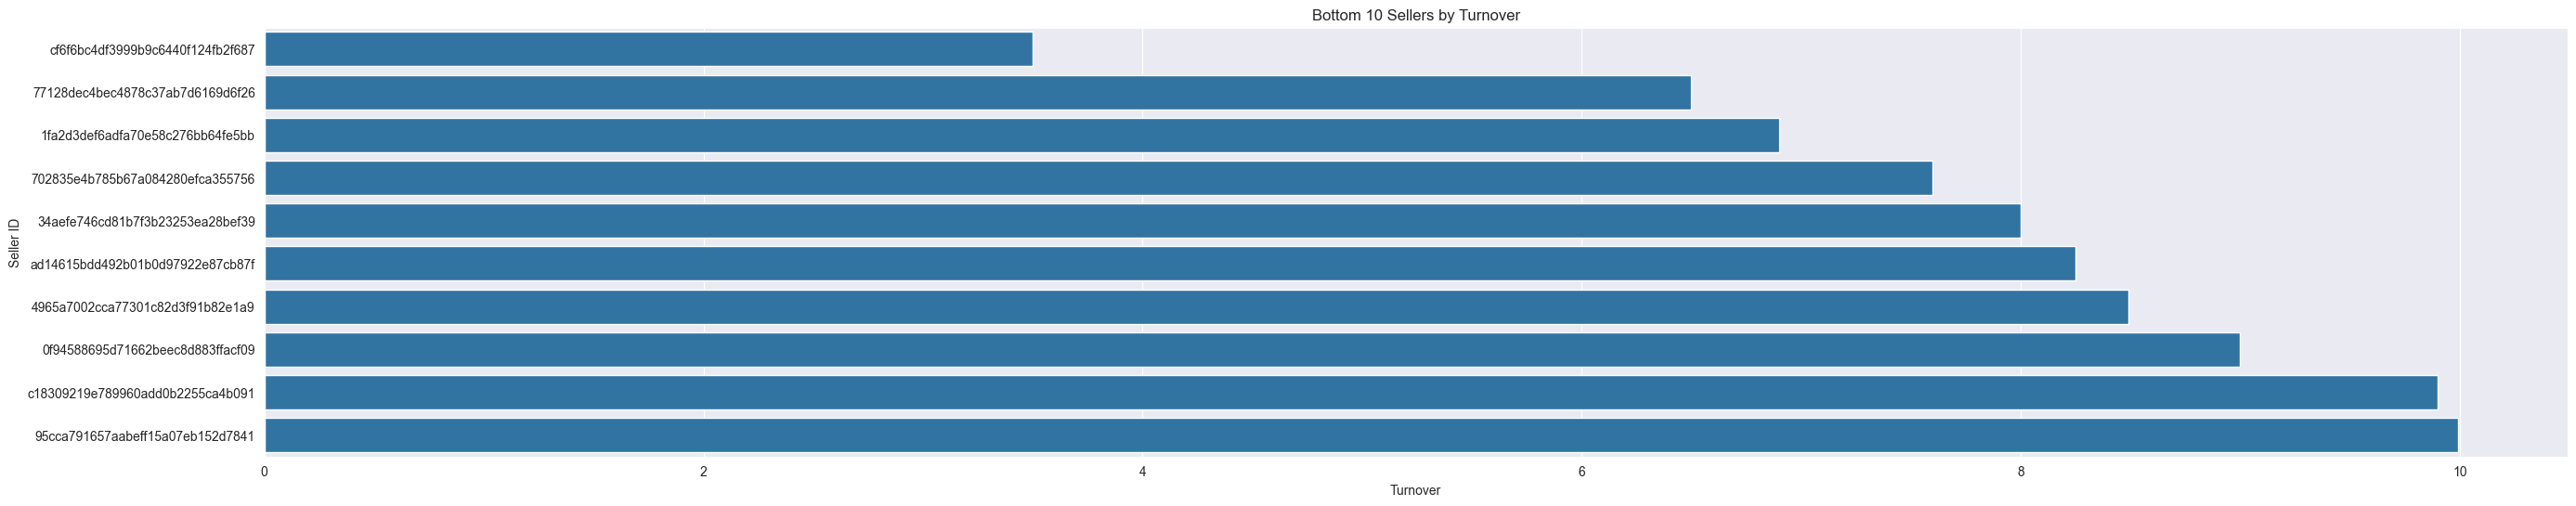

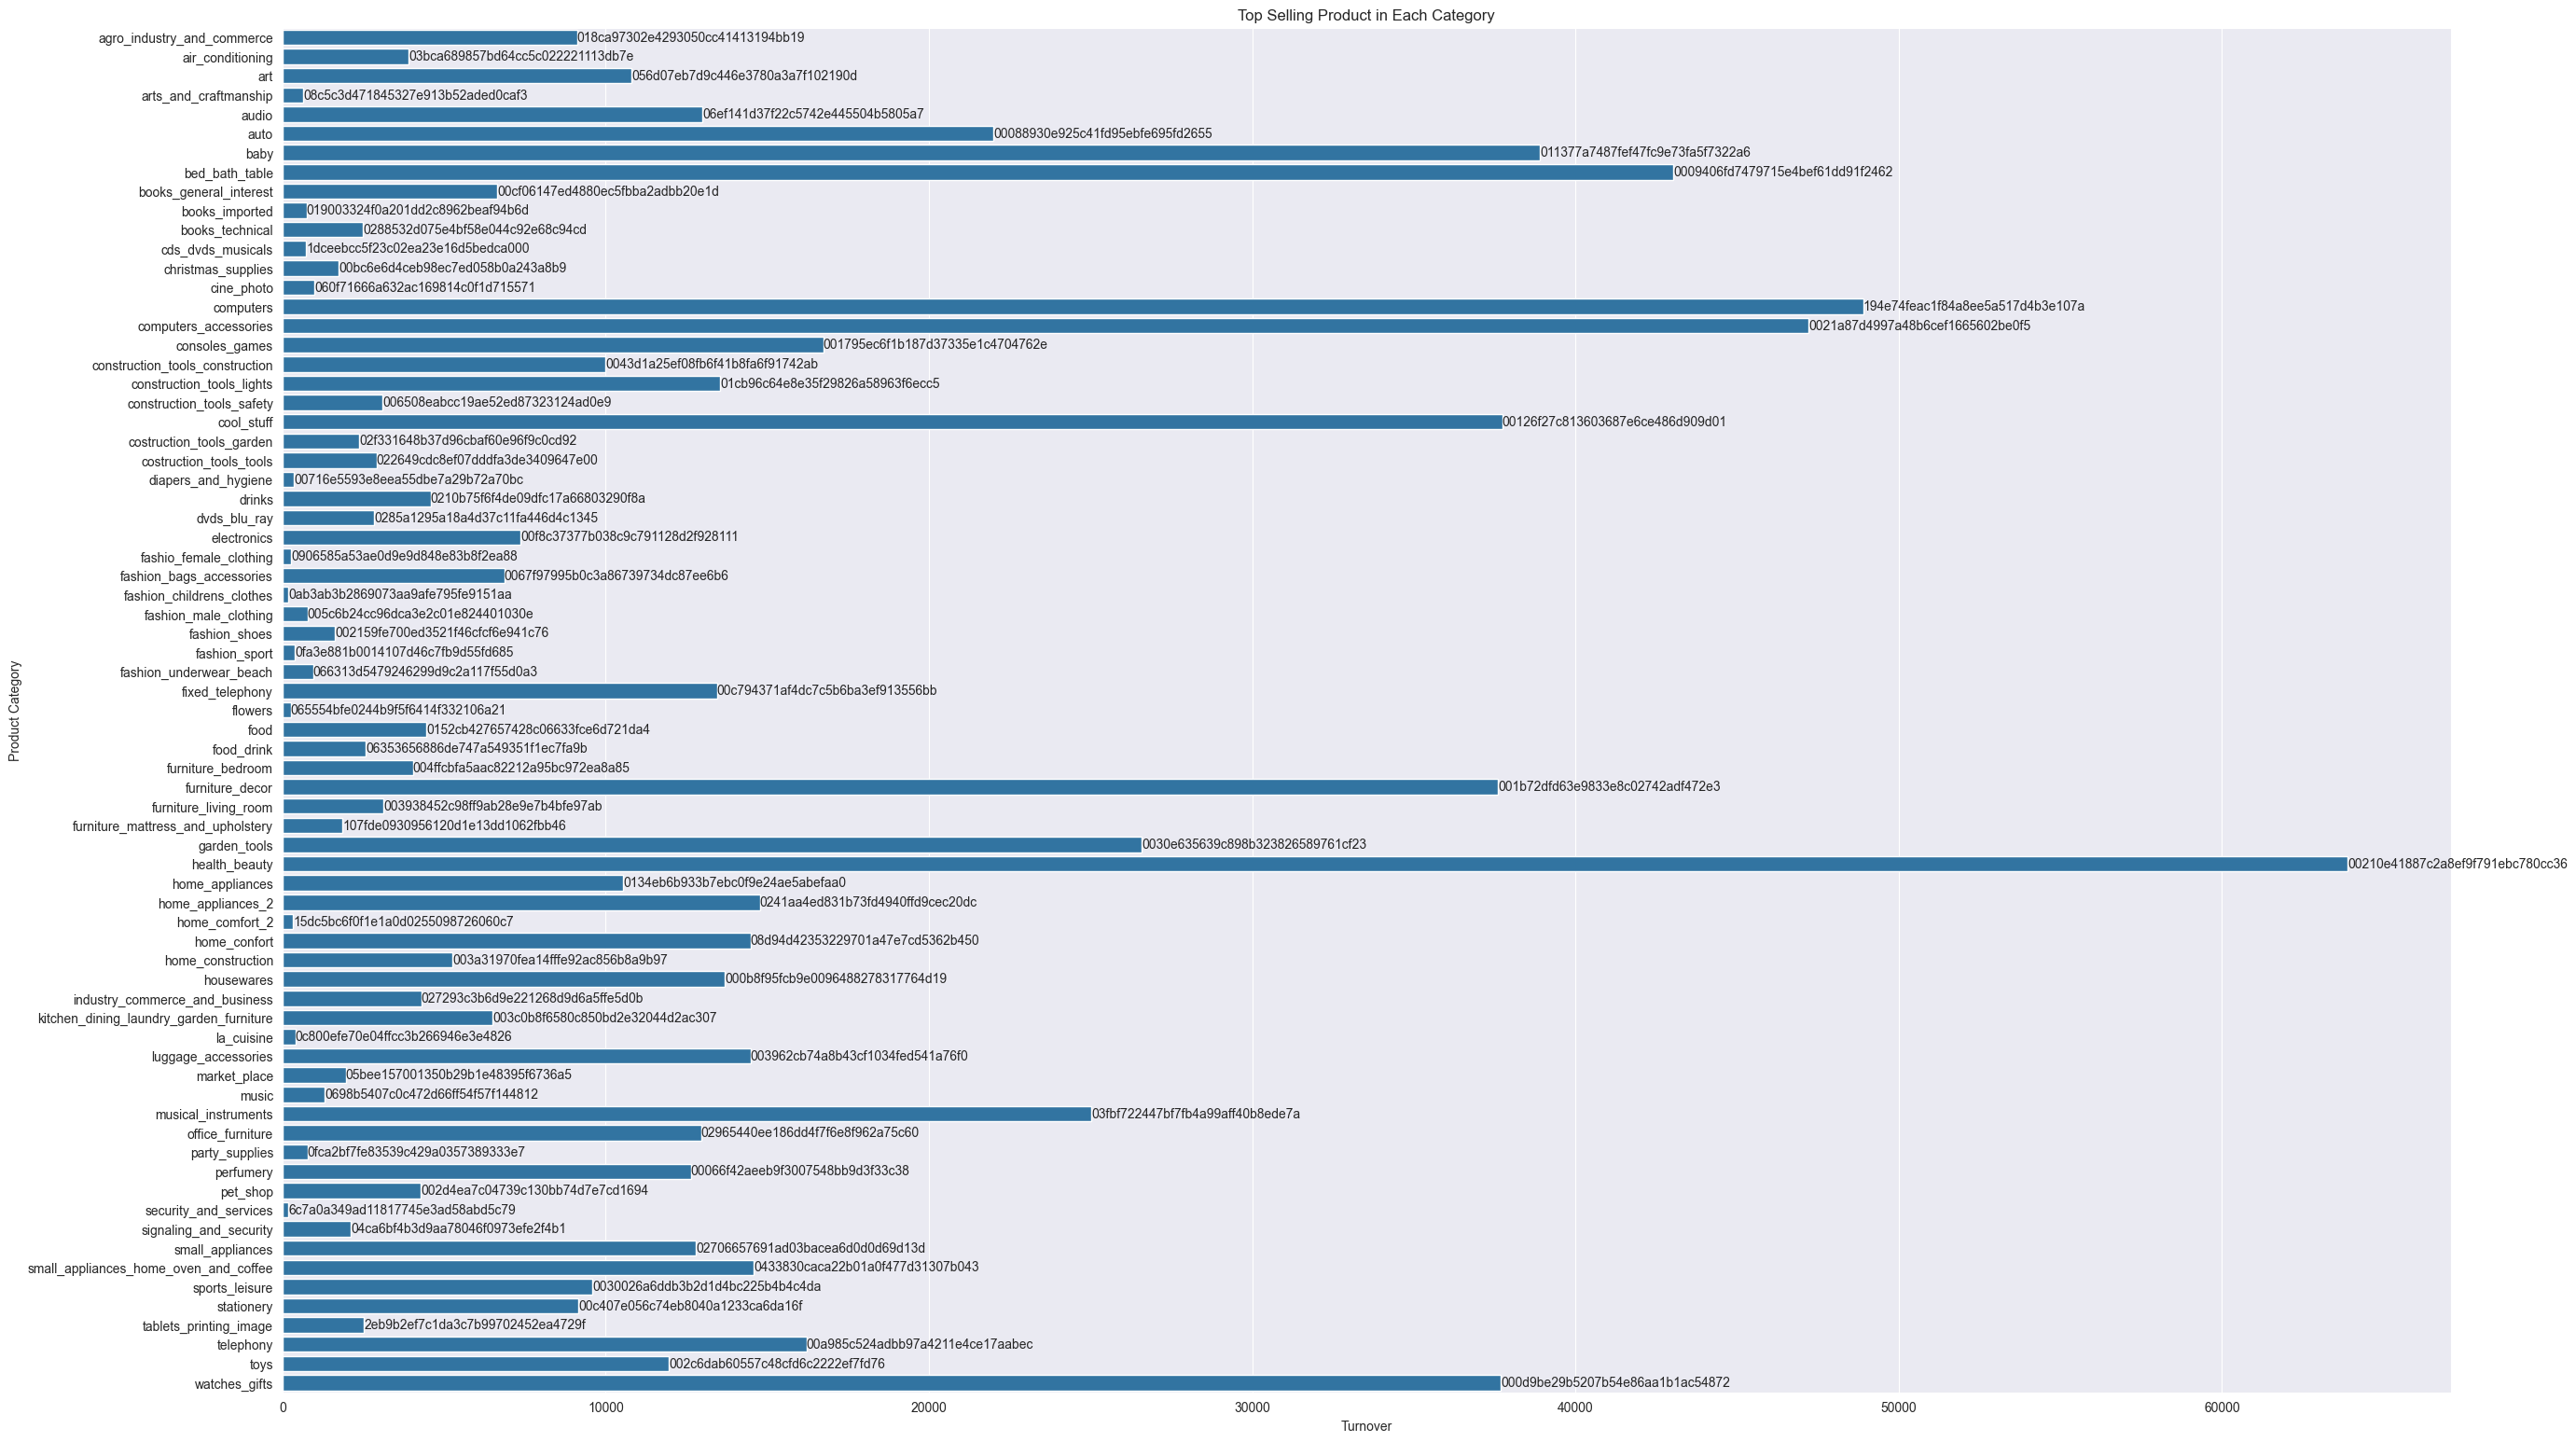

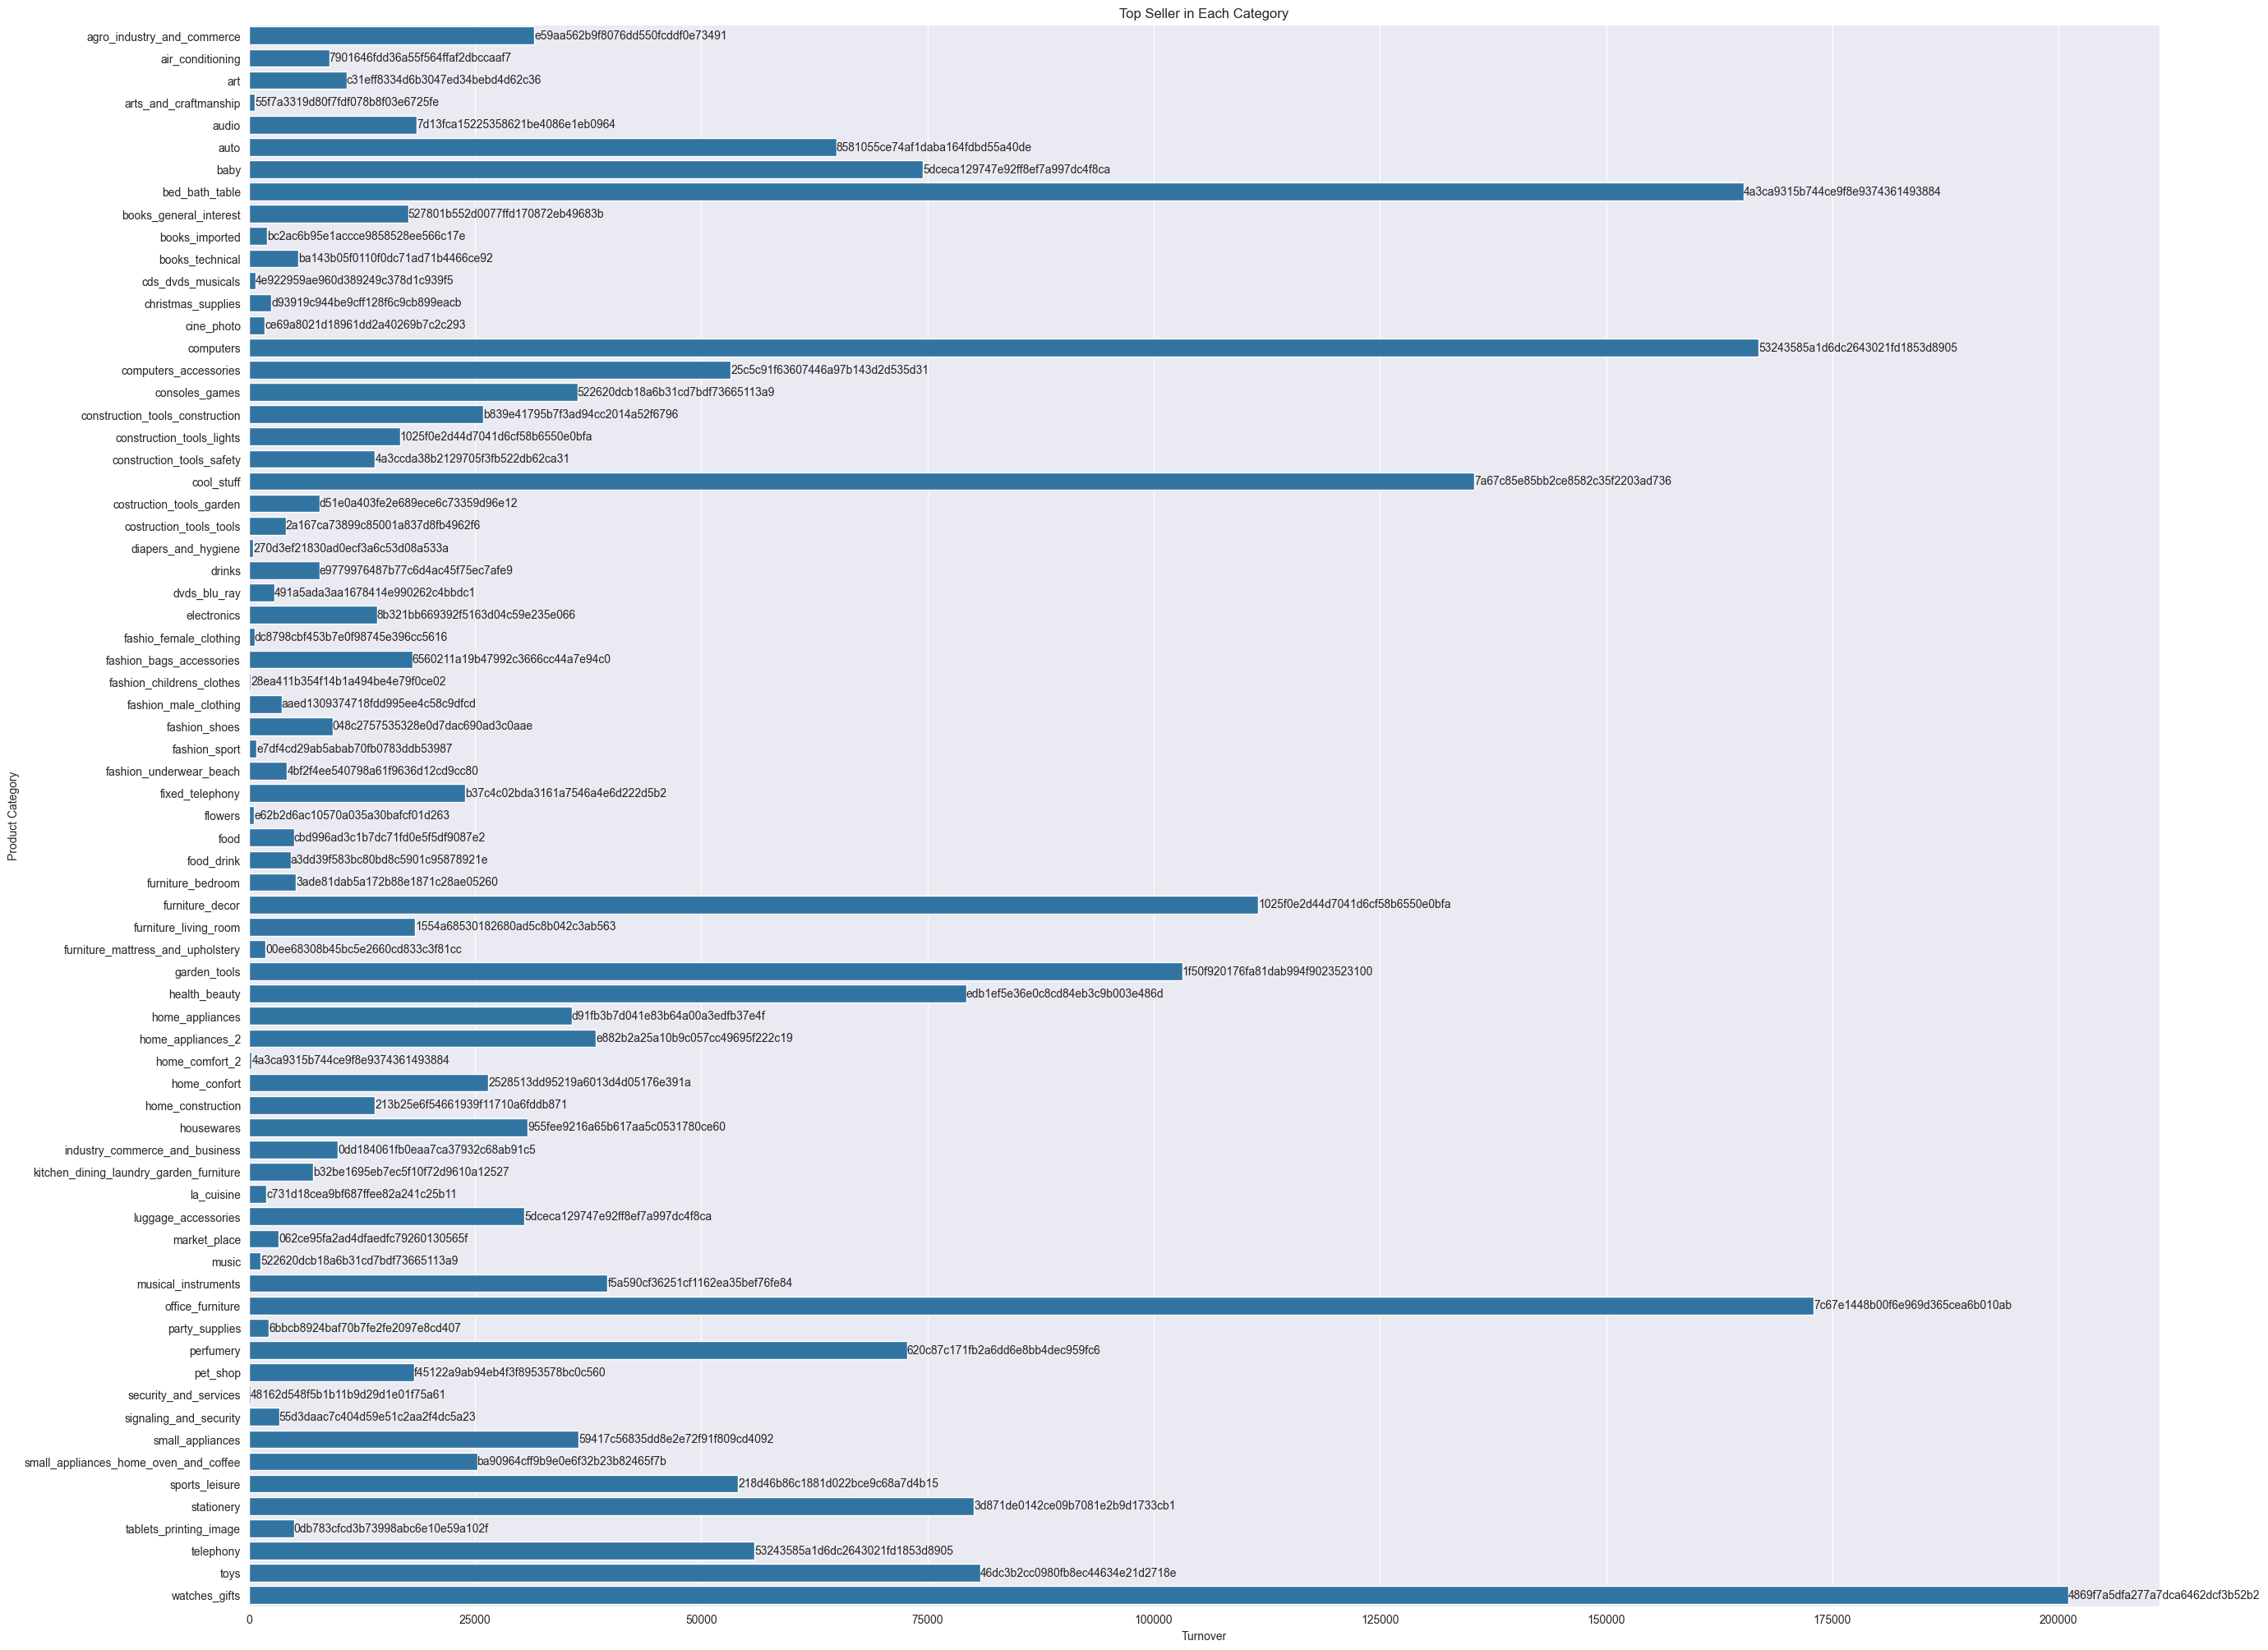

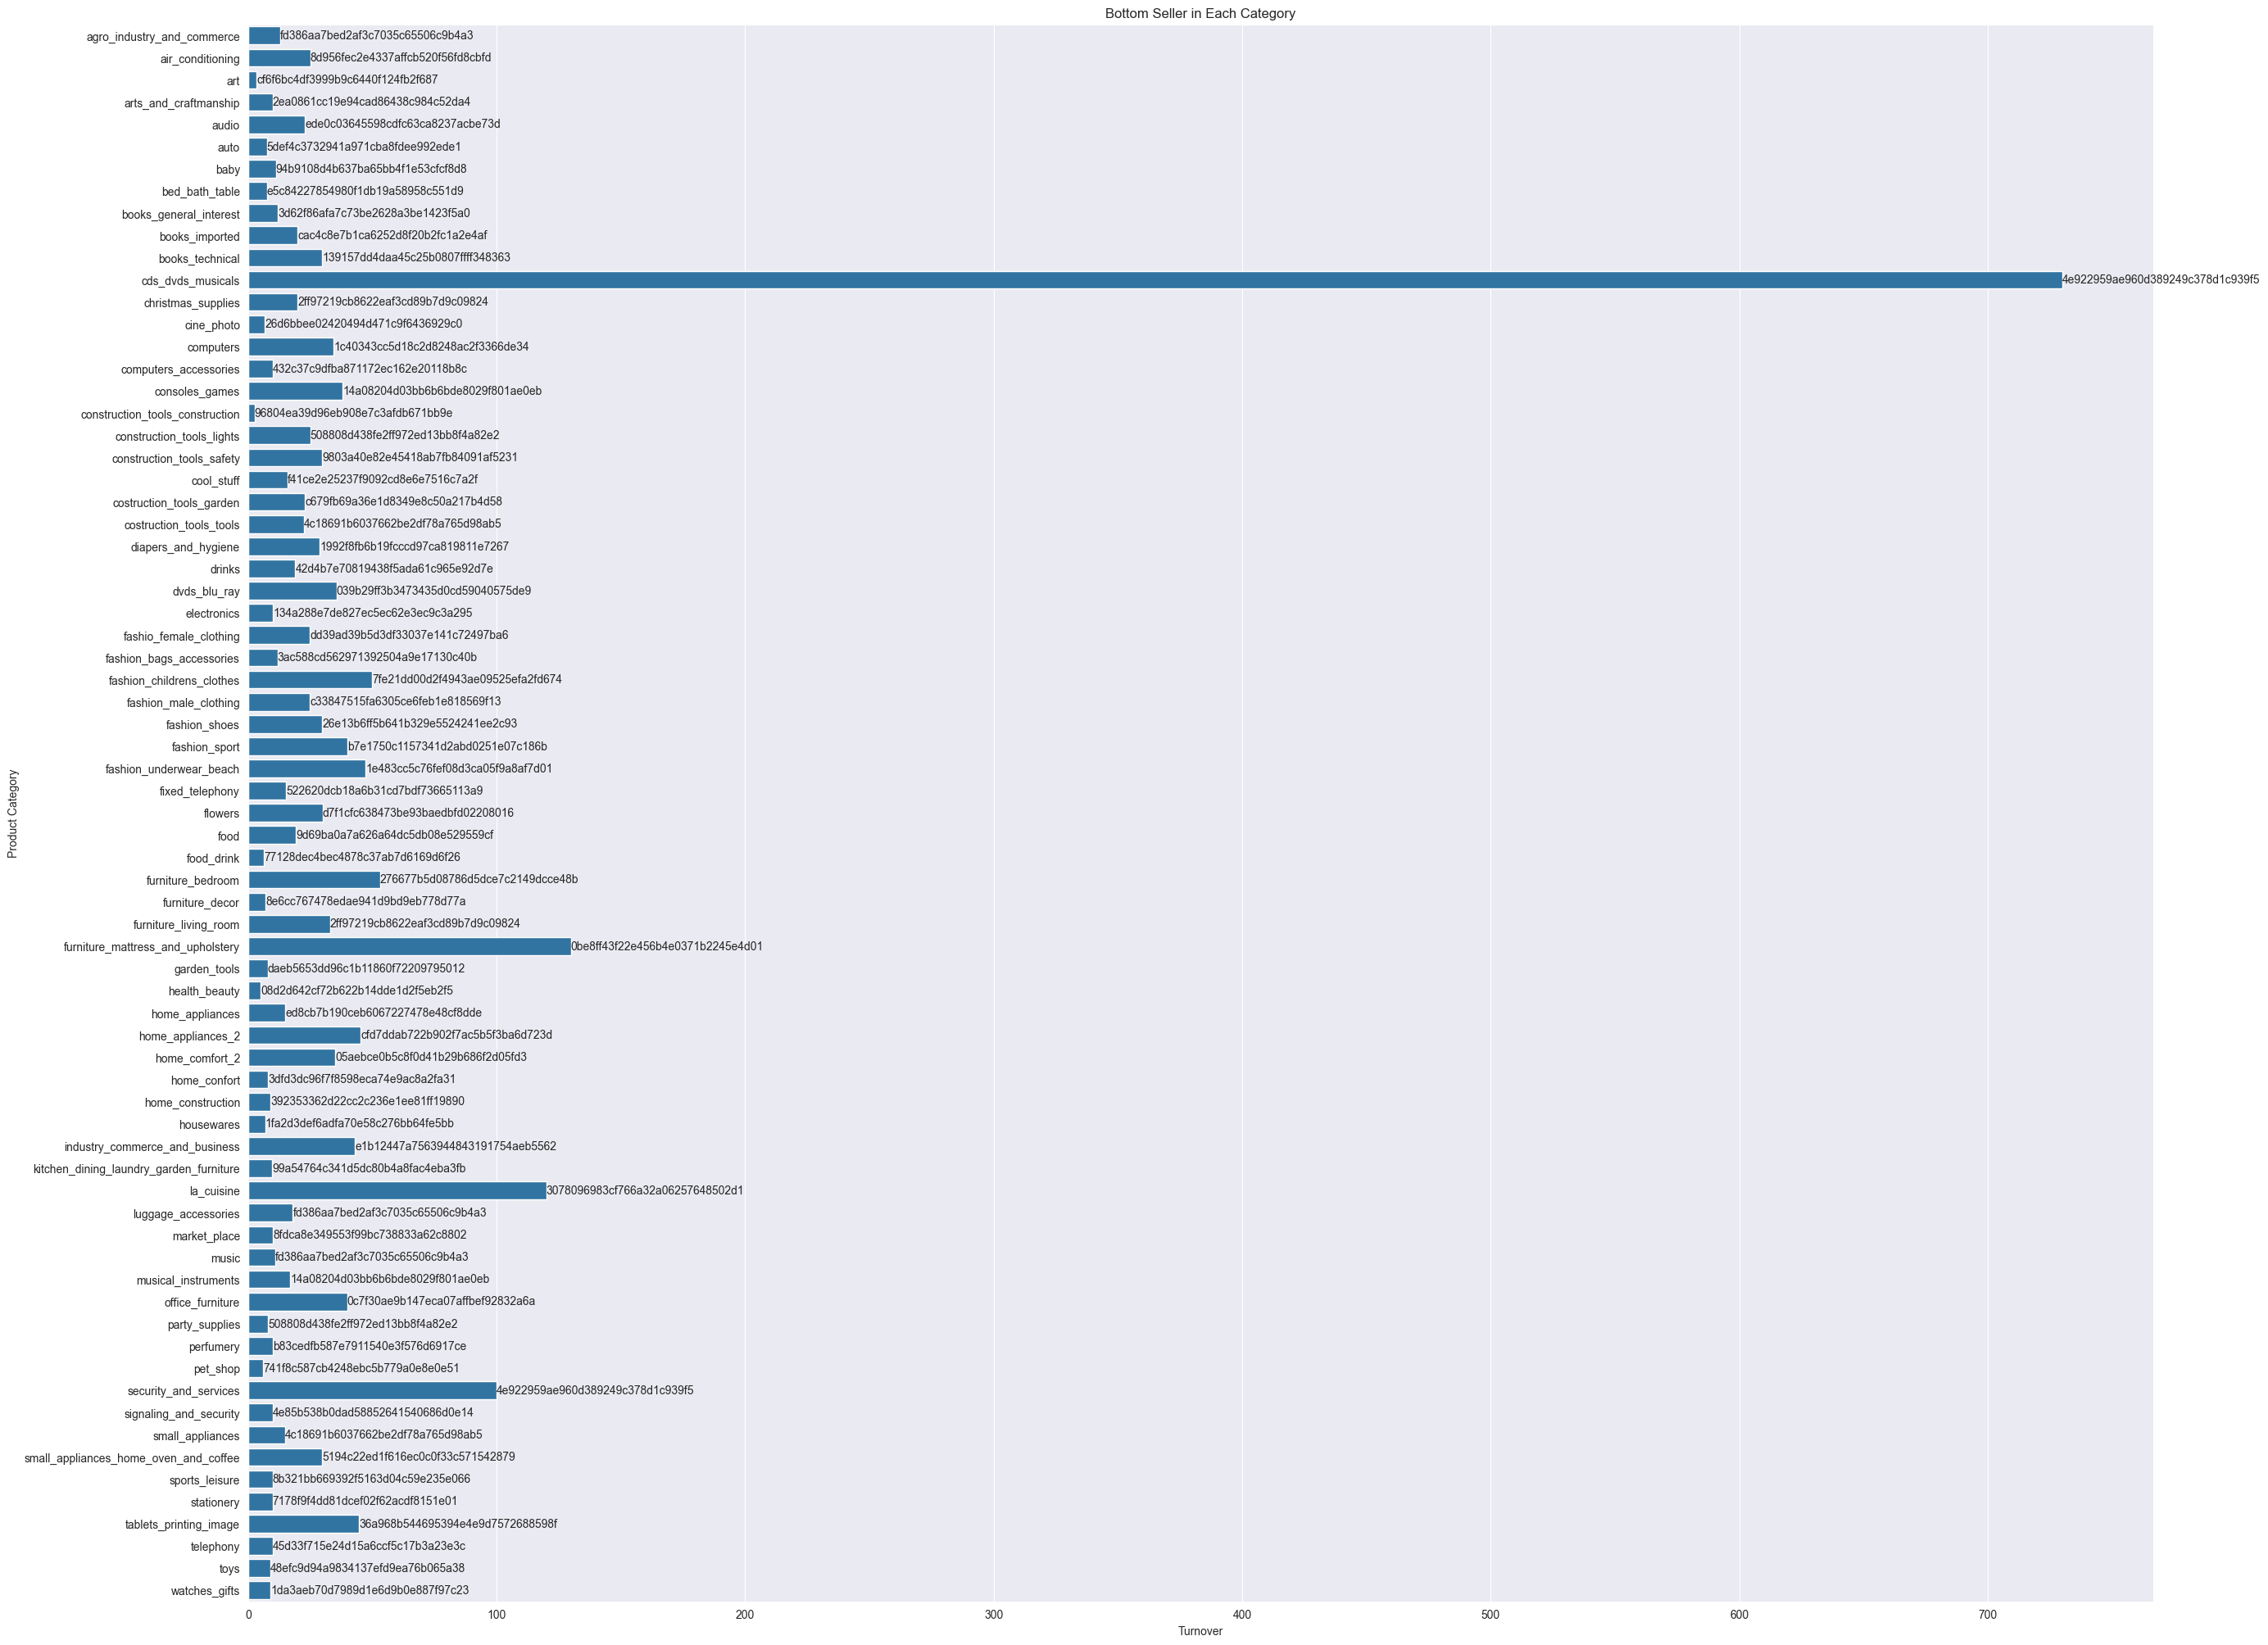

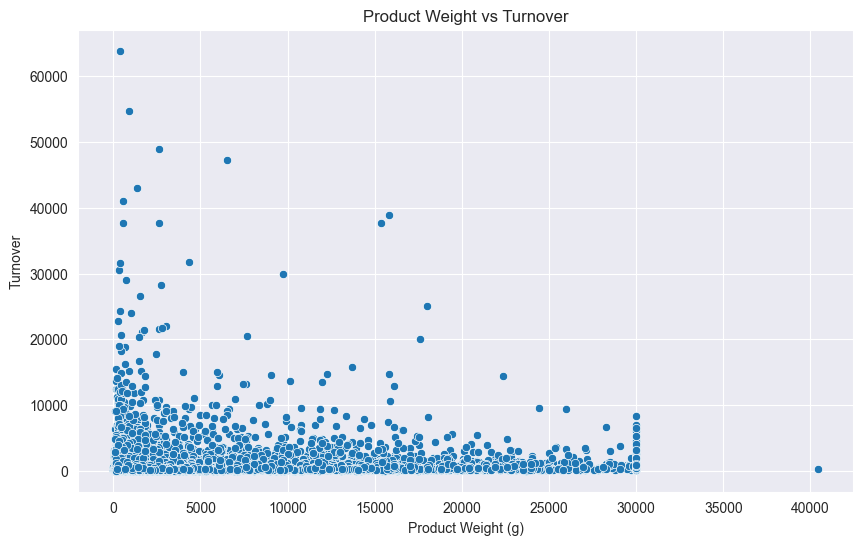

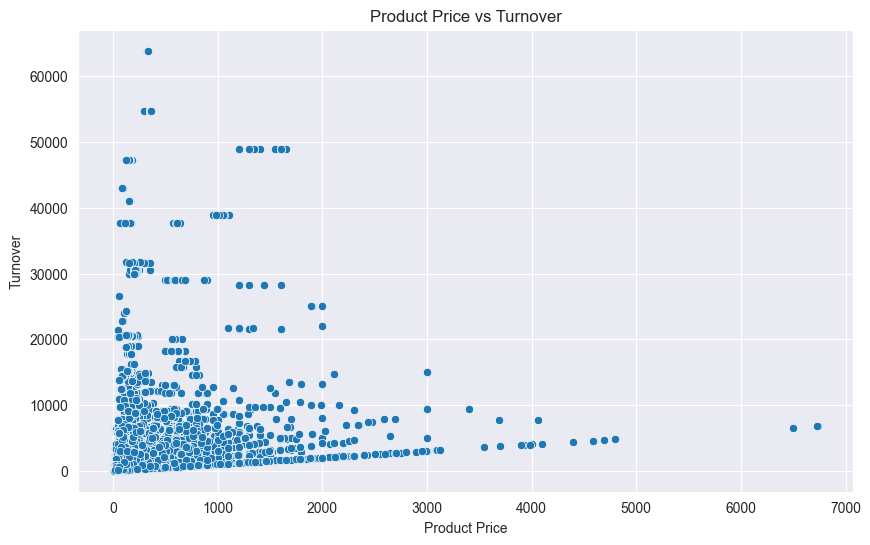

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import CSV files
customers = pd.read_csv('D:/Smart/S_Data/customers.csv')
orders = pd.read_csv('D:/Smart/S_Data/orders.csv')
products = pd.read_csv('D:/Smart/S_Data/products.csv')
order_items = pd.read_csv('D:/Smart/S_Data/order_items.csv')
product_category_name_translation = pd.read_csv('D:/Smart/S_Data/product_category_name_translation.csv')
sellers = pd.read_csv('D:/Smart/S_Data/sellers.csv')


# Translate product category names
products = products.merge(product_category_name_translation, on='product_category_name', how='left')

# Merge order data with product and seller data
order_items = order_items.merge(products, on='product_id')
order_items = order_items.merge(sellers, on='seller_id')
order_items = order_items.merge(orders, on='order_id')

# Calculate turnover for each seller
seller_turnover = order_items.groupby('seller_id')['price'].sum().reset_index()
seller_turnover.columns = ['seller_id', 'turnover']

# Sellers with the highest and lowest turnover
top_sellers = seller_turnover.nlargest(10, 'turnover')
bottom_sellers = seller_turnover.nsmallest(10, 'turnover')

# Calculate turnover for each product
product_turnover = order_items.groupby('product_id')['price'].sum().reset_index()
product_turnover.columns = ['product_id', 'turnover']

# Merge with product data to get categories
product_turnover = product_turnover.merge(products[['product_id', 'product_category_name_english']], on='product_id')


# Get the top-selling product in each category
def get_top_products(df):
    top_product = df.nlargest(1, 'turnover')
    top_product['product_category_name_english'] = df['product_category_name_english'].iloc[0]
    top_product['product_id'] = df['product_id'].iloc[0]
    return top_product


top_products_by_category = product_turnover.groupby('product_category_name_english', group_keys=False).apply(
    get_top_products).reset_index(drop=True)


# Get the top and bottom sellers in each category
def get_seller_stats(df):
    top_seller = df.groupby('seller_id')['price'].sum().nlargest(1).reset_index()
    bottom_seller = df.groupby('seller_id')['price'].sum().nsmallest(1).reset_index()
    top_seller['product_category_name_english'] = df['product_category_name_english'].iloc[0]
    bottom_seller['product_category_name_english'] = df['product_category_name_english'].iloc[0]
    return top_seller, bottom_seller


top_sellers_by_category = []
bottom_sellers_by_category = []

for name, group in order_items.groupby('product_category_name_english'):
    top_seller, bottom_seller = get_seller_stats(group)
    top_sellers_by_category.append(top_seller)
    bottom_sellers_by_category.append(bottom_seller)

top_sellers_by_category = pd.concat(top_sellers_by_category).reset_index(drop=True)
bottom_sellers_by_category = pd.concat(bottom_sellers_by_category).reset_index(drop=True)

# Analyze the relationship between product weight and turnover
product_weight_price = products[
    ['product_id', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']].merge(
    product_turnover, on='product_id')

# Visualization: Top 10 sellers by turnover
plt.figure(figsize=(32, 6))
sns.barplot(x='turnover', y='seller_id', data=top_sellers)
plt.title('Top 10 Sellers by Turnover')
plt.xlabel('Turnover')
plt.ylabel('Seller ID')
plt.show()

# Visualization: Bottom 10 sellers by turnover
plt.figure(figsize=(32, 6))
sns.barplot(x='turnover', y='seller_id', data=bottom_sellers)
plt.title('Bottom 10 Sellers by Turnover')
plt.xlabel('Turnover')
plt.ylabel('Seller ID')
plt.show()

# Visualization: Top-selling product in each category
plt.figure(figsize=(30, 19))
ax = sns.barplot(x='turnover', y='product_category_name_english', data=top_products_by_category)
plt.title('Top Selling Product in Each Category')
plt.xlabel('Turnover')
plt.ylabel('Product Category')

# Add product IDs as labels on the bars
for container in ax.containers:
    labels = [f"{product_id}" for product_id in top_products_by_category['product_id']]
    ax.bar_label(container, labels=labels, label_type='edge')

plt.show()

# Visualization: Top seller in each category
plt.figure(figsize=(30, 25))
ax = sns.barplot(x='price', y='product_category_name_english', data=top_sellers_by_category, errorbar=None)
plt.title('Top Seller in Each Category')
plt.xlabel('Turnover')
plt.ylabel('Product Category')

# Add seller IDs as labels on the bars
for container in ax.containers:
    ax.bar_label(container, labels=top_sellers_by_category['seller_id'].tolist(), label_type='edge')

plt.show()

# Visualization: Bottom seller in each category
plt.figure(figsize=(30, 25))
ax = sns.barplot(x='price', y='product_category_name_english', data=bottom_sellers_by_category, errorbar=None)
plt.title('Bottom Seller in Each Category')
plt.xlabel('Turnover')
plt.ylabel('Product Category')

# Add seller IDs as labels on the bars
for container in ax.containers:
    ax.bar_label(container, labels=bottom_sellers_by_category['seller_id'].tolist(), label_type='edge')

plt.show()

# Relationship between product weight and turnover
if 'product_weight_g' in product_weight_price.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='product_weight_g', y='turnover', data=product_weight_price)
    plt.title('Product Weight vs Turnover')
    plt.xlabel('Product Weight (g)')
    plt.ylabel('Turnover')
    plt.show()

# Relationship between product price and turnover
order_items_with_turnover = order_items.merge(product_turnover[['product_id', 'turnover']], on='product_id')

if 'price' in order_items_with_turnover.columns and 'turnover' in order_items_with_turnover.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='price', y='turnover', data=order_items_with_turnover)
    plt.title('Product Price vs Turnover')
    plt.xlabel('Product Price')
    plt.ylabel('Turnover')
    plt.show()
